# Controlled Simple Transport Model

We use the model described in *Simple_Transport*.
After some imports:

In [1]:
from matplotlib import pyplot as plt
from pymf6.mf6 import MF6
from pymf6tools.plotting import show_heads, show_well_head, show_concentration
from pymf6tools.make_model import get_simulation
from create_model import create_model

we use a different model path:

In [2]:
model_path_controlled = 'models/pymf6'
name = 'transport'

but buIld exactly the same model:

In [3]:
create_model(model_path_controlled, name)

Now, we can inspect the model by instantiating `MF6` form `pymf6`:

In [4]:
mf6 = MF6(model_path_controlled + '/mfsim.nam', use_modflow_api=False)

We can access the simulations:

In [5]:
sim = mf6.simulation

There are to simulations, one for flow `gwf6` and one for transport `gwt6`:

In [6]:
sim

modeltype,namefile,modelname
gwf6,transport.nam,TRANSPORT
gwt6,gwt_transport.nam,GWT_TRANSPORT


The simulations have different packages:

In [7]:
sim.models

[Model TRANSPORT 
 15 packages
 49 variables.,
 Model GWT_TRANSPORT 
 12 packages
 42 variables.]

There are also two solution groups, one for each simulation:

In [8]:
sim.solution_groups

[Solution 1 
 1 packages
 68 variables.,
 Solution 2 
 1 packages
 68 variables.]

The time discretization is the same for both simulations:

In [9]:
sim.TDIS

number of variables:,19


There are many model variables:

In [10]:
len(mf6.vars)

881

This is an alternative method to get the number of simulations:

In [11]:
mf6._mf6.get_subcomponent_count()

2

The solution variable in the first solution is the head and in the
second the concentration:

In [12]:
conc_array = mf6.vars['SLN_2/X'].reshape(10, 10)
wel = mf6.vars['TRANSPORT/WEL-1/BOUND']

We get a hold of the time steps:

In [13]:
steps = mf6.steps()

We specify a linear relationship between the concentration at the right border
and the pumping rate:

In [14]:
concs_rates = [
    (2.5, -0.6),
    (2.4, -0.5),
    (2.2, -0.4),
    (2.1, -0.3),
    (2.0, -0.2),
    (1.9, -0.1),
]

Now iterate of all time steps and modify the pumping rate based on the
concentration at the right model boundary:

In [15]:
for time_step in steps:
    modelled_conc = conc_array[1:-1, -1].max()
    for conc, rate in concs_rates:
        if modelled_conc > conc:
            wel[:] = rate
            break
    else:  # no `break` reached
        wel[:] = 0

This is the highest concentration at the right hand side at the end of the controlled
model run:

In [16]:
round(conc_array[1:-1, -1].max(), 1)

2.0

The heads show that the well pumping reverts the flow direction, 
i.e. the flow is now from the right model border towards the well.

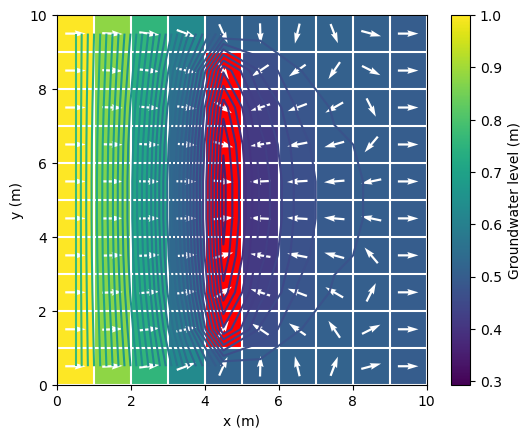

In [17]:
show_heads(model_path=model_path_controlled, name=name, title='');

The target concentration of about 2 mg/L at the right border has
been achieved:

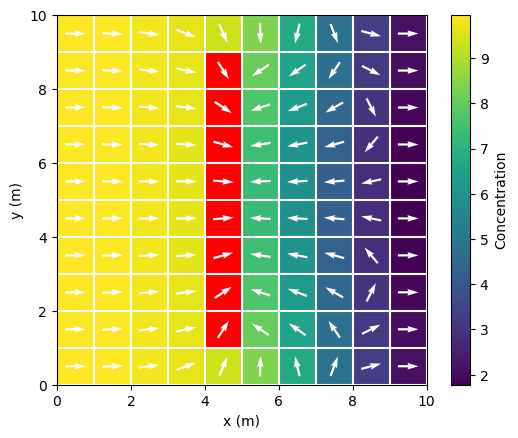

In [18]:
show_concentration(model_path=model_path_controlled, name=name, show_contours=False, show_arrows=True);
plt.savefig('conc.svg', bbox_inches='tight')